In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
# load local version of gallifrey, before pip installed version, for debugging
import pathlib
import sys
import os

sys.path.append(str(pathlib.Path(os.getcwd()).parent.joinpath("src")))

In [3]:
import yt
import numpy as np
import matplotlib.pyplot as plt

from gallifrey.setup import data_setup
from gallifrey.utilities.math import calculate_pca
from gallifrey.particles import rotated_dataset

## DATA SETUP

In [4]:
snapshot = 127
resolution = 4096
sim_id = "09_18"
num_embryos = 50
# host_star_masses = (0.1, 0.3, 0.5, 0.7, 1)
host_star_masses = 1
planet_categories = [
    "Earth",
    "Super-Earth",
    "Neptunian",
    "Sub-Giant",
    "Giant",
    "D-Burner",
]
save = False

In [5]:
ds, mw, stellar_model, imf, planet_model = data_setup(
    snapshot=snapshot,
    resolution=resolution,
    sim_id=sim_id,
    ngpps_num_embryos=num_embryos,
    ngpps_star_masses=host_star_masses,
)


      DETECTED LOCAL MACHINE: Test snapshot loaded.

yt : [INFO     ] 2023-07-07 11:21:20,245 Calculating time from 1.000e+00 to be 4.318e+17 seconds
yt : [INFO     ] 2023-07-07 11:21:20,301 Parameters: current_time              = 4.318436660023809e+17 s
yt : [INFO     ] 2023-07-07 11:21:20,302 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2023-07-07 11:21:20,303 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2023-07-07 11:21:20,303 Parameters: domain_right_edge         = [100. 100. 100.]
yt : [INFO     ] 2023-07-07 11:21:20,304 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2023-07-07 11:21:20,304 Parameters: current_redshift          = 4.440892098500626e-16
yt : [INFO     ] 2023-07-07 11:21:20,304 Parameters: omega_lambda              = 0.682
yt : [INFO     ] 2023-07-07 11:21:20,305 Parameters: omega_matter              = 0.318
yt : [INFO     ] 2023-07-07 11:21:20,306 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 202

## PLOT SETUP

In [6]:
from planet_maps import plot_maps
from planet_1dprofiles import plot_1dprofiles
from planet_2dprofiles import plot_2dprofiles

## CREATE DATA SOURCE

In [7]:
radius = 80 # can contain a cube of 80/sqrt(3) = 46 kpc, so plots with a smaller width will have no edge effects
normal_vector = calculate_pca(
    mw.sphere(radius=(10, "kpc"))["stars", "Coordinates"]
).components_[-1]

In [8]:
sphere_data = mw.sphere(radius=ds.quan(radius, "kpc"))

rotated_disk_data = rotated_dataset(
    mw.disk(
        radius=ds.quan(radius, "kpc"), height=ds.quan(0.5, "kpc"), normal=normal_vector
    ),
    mw.centre(),
    normal_vector,
    [
        ("stars", "[Fe/H]"),
        ("stars", "number"),
        *[("stars", f"{category}") for category in planet_categories],
    ],
)

rotated_sphere_data = rotated_dataset(
    sphere_data,
    mw.centre(),
    normal_vector,
    [
        ("stars", "[Fe/H]"),
        ("stars", "number"),
        *[("stars", f"{category}") for category in planet_categories],
    ],
)

yt : [INFO     ] 2023-07-07 11:21:32,329 Parameters: current_time              = 0.0
yt : [INFO     ] 2023-07-07 11:21:32,330 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2023-07-07 11:21:32,330 Parameters: domain_left_edge          = [-65.17847254 -65.17847254 -65.17847254]
yt : [INFO     ] 2023-07-07 11:21:32,331 Parameters: domain_right_edge         = [70.11069859 70.11069859 70.11069859]
yt : [INFO     ] 2023-07-07 11:21:32,332 Parameters: cosmological_simulation   = 0
yt : [INFO     ] 2023-07-07 11:21:32,333 Allocating for 1.3e+05 particles
yt : [INFO     ] 2023-07-07 11:21:41,265 Parameters: current_time              = 0.0
yt : [INFO     ] 2023-07-07 11:21:41,266 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2023-07-07 11:21:41,266 Parameters: domain_left_edge          = [-78.5896246 -78.5896246 -78.5896246]
yt : [INFO     ] 2023-07-07 11:21:41,267 Parameters: domain_right_edge         = [79.26039752 79.26039752 79.26039752]
yt : [INFO     ]

## FACE-ON MAPS

yt : [INFO     ] 2023-07-07 11:21:41,518 xlim = -21.314614 21.985386
yt : [INFO     ] 2023-07-07 11:21:41,519 ylim = -21.314614 21.985386
yt : [INFO     ] 2023-07-07 11:21:41,521 xlim = -21.314614 21.985386
yt : [INFO     ] 2023-07-07 11:21:41,522 ylim = -21.314614 21.985386
yt : [INFO     ] 2023-07-07 11:21:41,524 Splatting (('stars', 'Neptunian')) onto a 800 by 800 mesh using method 'cic'
yt : [INFO     ] 2023-07-07 11:21:41,877 Splatting (('stars', 'Super-Earth')) onto a 800 by 800 mesh using method 'cic'
yt : [INFO     ] 2023-07-07 11:21:42,135 Splatting (('stars', 'Earth')) onto a 800 by 800 mesh using method 'cic'
yt : [INFO     ] 2023-07-07 11:21:42,295 Splatting (('stars', 'Giant')) onto a 800 by 800 mesh using method 'cic'
yt : [INFO     ] 2023-07-07 11:21:42,467 Splatting (('stars', 'Sub-Giant')) onto a 800 by 800 mesh using method 'cic'
yt : [INFO     ] 2023-07-07 11:21:42,641 Splatting (('stars', 'D-Burner')) onto a 800 by 800 mesh using method 'cic'
yt : [INFO     ] 2023-0

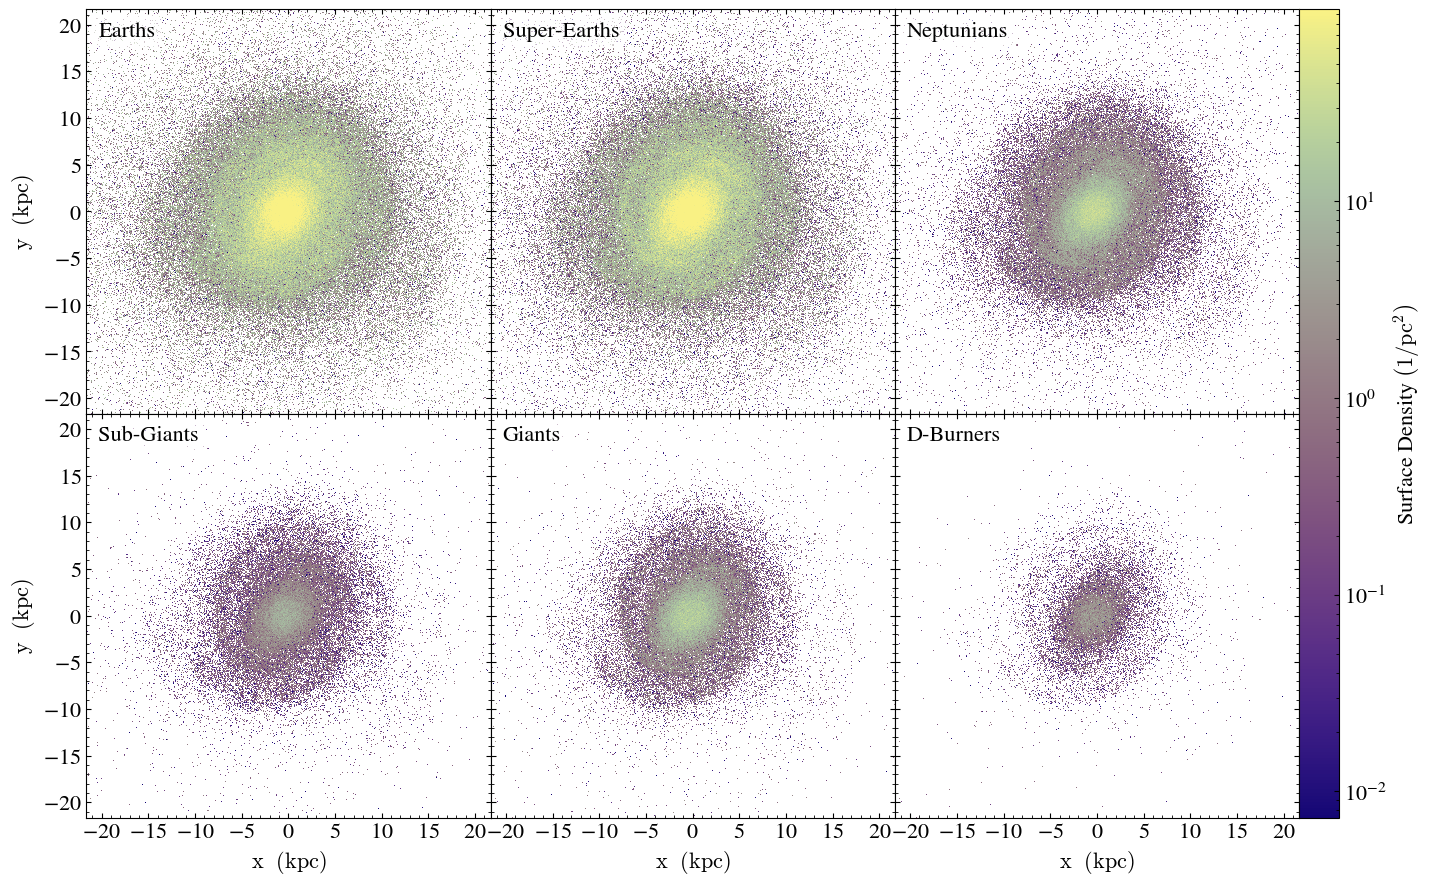

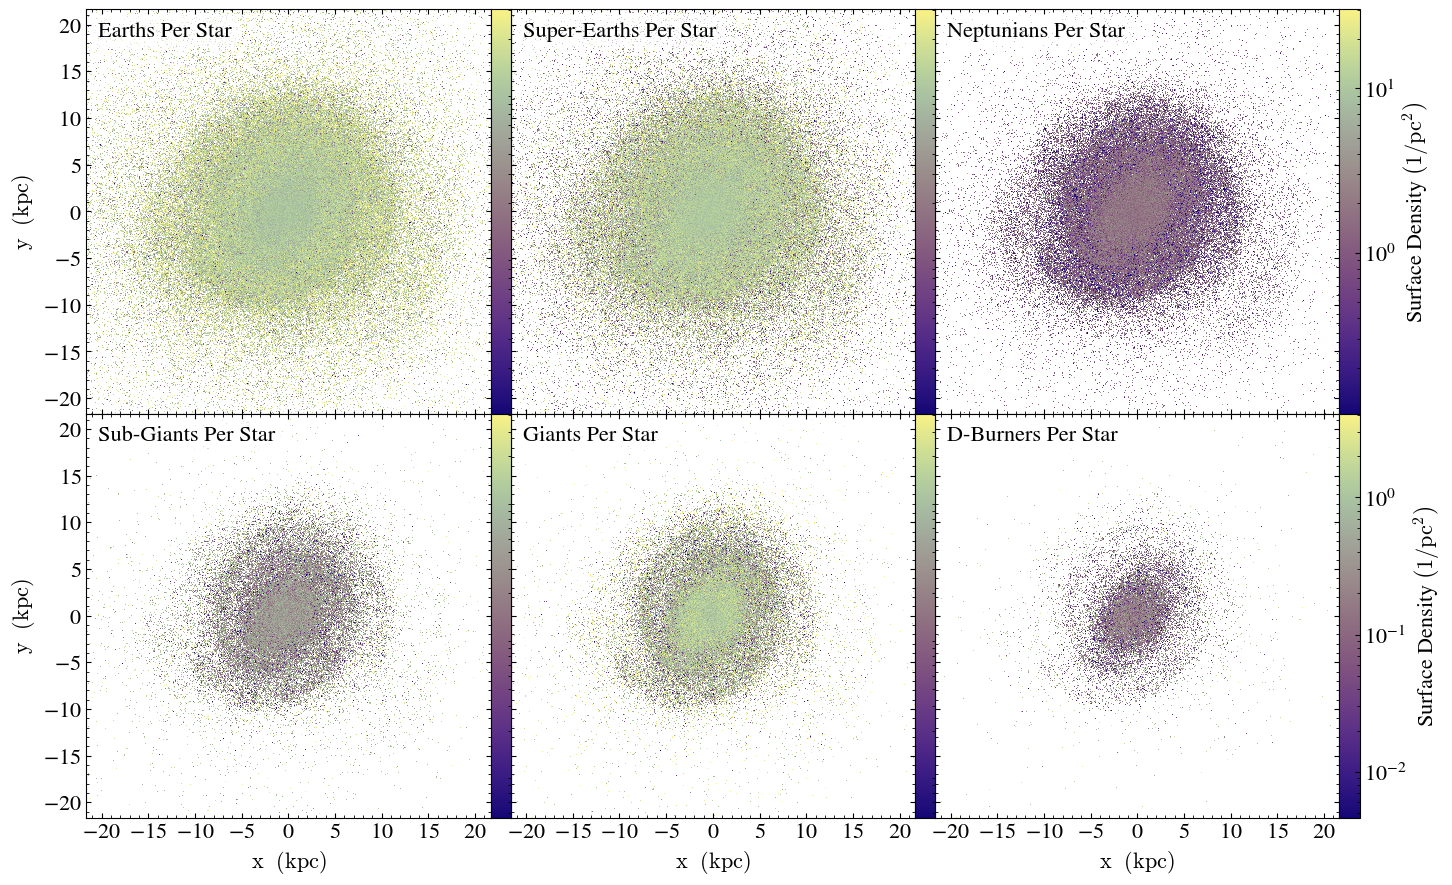

In [9]:
zplot, zfig = plot_maps(
    planet_categories,
    rotated_sphere_data,
    normal="z",
    colorbar_normalisation="global",
    subplot_pad=0,
    save=save,
)
zplot_per_star, zfig_per_star = plot_maps(
    planet_categories,
    rotated_sphere_data,
    normal="z",
    weight_field=("stars", "number"),
    colorbar_normalisation="row",
    subplot_pad=(0, 0),
    save=save,
)

## SIDE-ON MAPS

yt : [INFO     ] 2023-07-07 11:22:22,927 xlim = -21.314614 21.985386
yt : [INFO     ] 2023-07-07 11:22:22,928 ylim = -21.314614 21.985386
yt : [INFO     ] 2023-07-07 11:22:22,929 xlim = -21.314614 21.985386
yt : [INFO     ] 2023-07-07 11:22:22,930 ylim = -21.314614 21.985386
yt : [INFO     ] 2023-07-07 11:22:22,931 Splatting (('stars', 'Neptunian')) onto a 800 by 800 mesh using method 'cic'
yt : [INFO     ] 2023-07-07 11:22:23,129 Splatting (('stars', 'Super-Earth')) onto a 800 by 800 mesh using method 'cic'
yt : [INFO     ] 2023-07-07 11:22:23,298 Splatting (('stars', 'Earth')) onto a 800 by 800 mesh using method 'cic'
yt : [INFO     ] 2023-07-07 11:22:23,456 Splatting (('stars', 'Giant')) onto a 800 by 800 mesh using method 'cic'
yt : [INFO     ] 2023-07-07 11:22:23,782 Splatting (('stars', 'Sub-Giant')) onto a 800 by 800 mesh using method 'cic'
yt : [INFO     ] 2023-07-07 11:22:23,947 Splatting (('stars', 'D-Burner')) onto a 800 by 800 mesh using method 'cic'
yt : [INFO     ] 2023-0

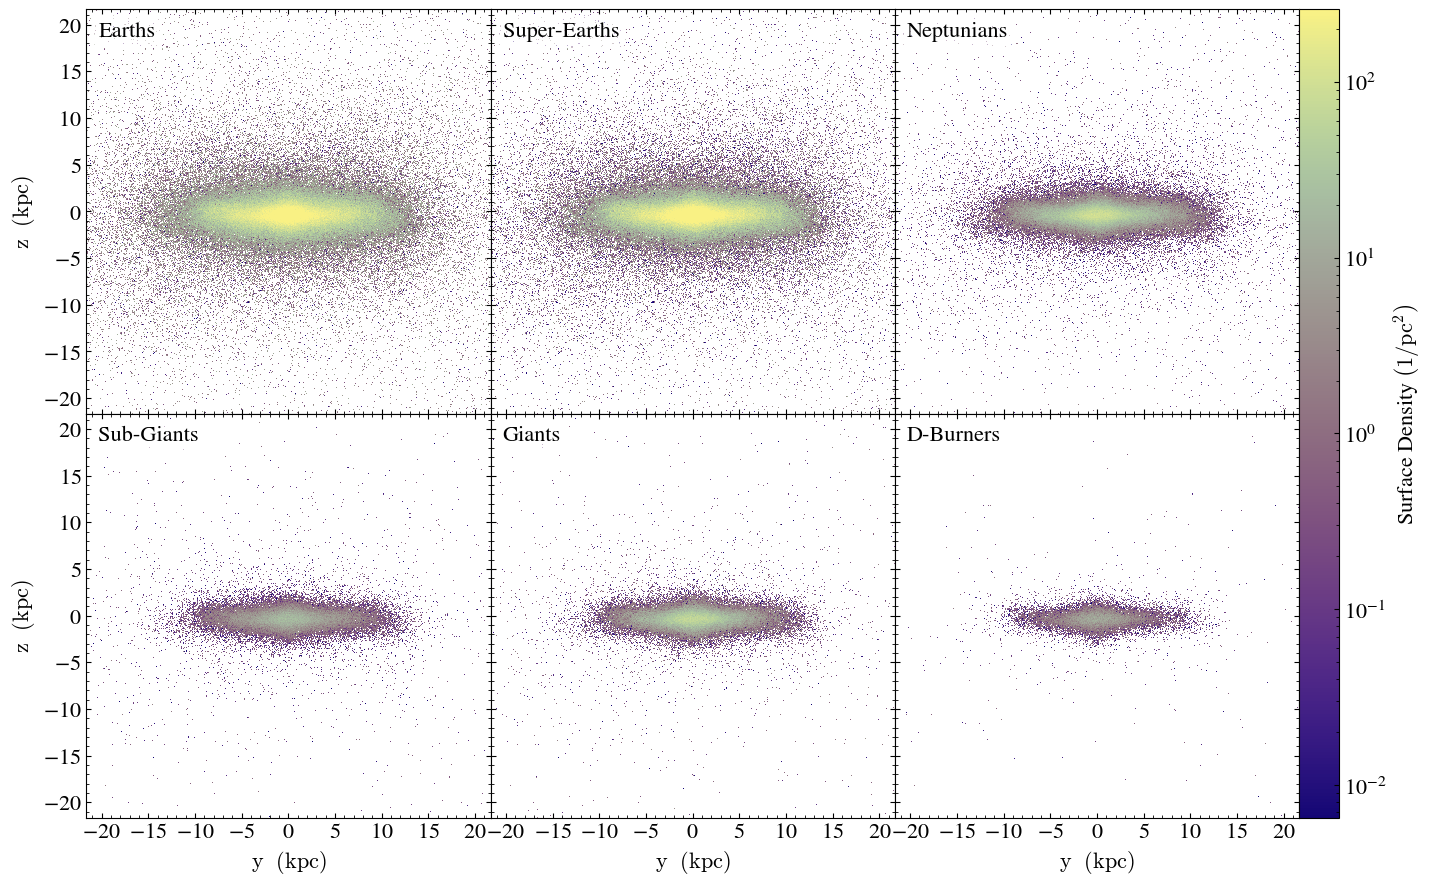

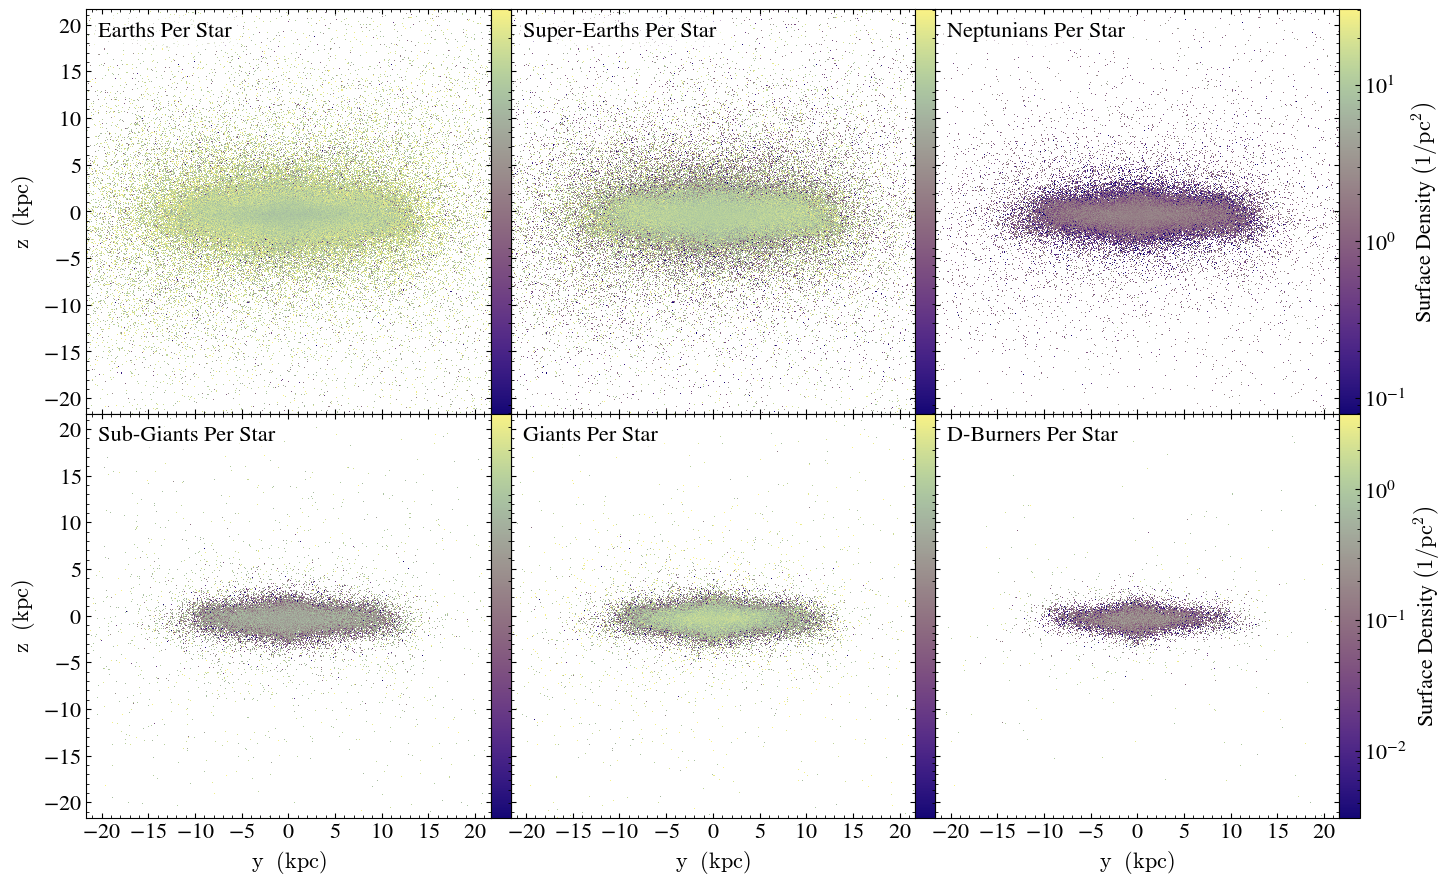

In [10]:
zplot, zfig = plot_maps(
    planet_categories,
    rotated_sphere_data,
    normal="x",
    colorbar_normalisation="global",
    subplot_pad=0,
    save=save,
)
zplot_per_star, zfig_per_star = plot_maps(
    planet_categories,
    rotated_sphere_data,
    normal="x",
    weight_field=("stars", "number"),
    colorbar_normalisation="row",
    subplot_pad=(0, 0),
    save=save,
)

## 1D Profiles

## 2D Profiles